In [1]:
import argparse
import json
import os
import pathlib
import pickle as pkl
import shutil
import sys
import time
import warnings
from collections import defaultdict
from typing import Dict, List, Optional

import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

### schema
import uproot
import mplhep as hep

from sklearn.metrics import auc, roc_curve

plt.style.use(hep.style.CMS)

### awkward 1.10.0
sys.path.append("../")

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Missing cross-reference index ")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%load_ext autoreload
%autoreload 2

# Weaver output

In [3]:
legend_dict = {
    "higgs": "Matched Higgs",
    "W": "W+JetsLNu",
    "W_merged": "W merged",
    "W_unmatched": "W unmatched",
    "top": "TTbar",
    "top_fully_merged": "Top: fully merged",
    "top_W_merged": "Top: only W merged",
    "top_unmatched": "Top: unmatched",
    "qcd": "QCD"
}

bins=40
def make_1d_hists(events, tag, save_as=None):
    """
    Args
        sample [str]: choices are 
            ["higgs", "W_merged", "W_unmatched", "top_fully_merged", "top_W_merged", "top_unmatched", "qcd"]
        events [uproot Tree]: the uproot event Tree
        bins [int]: histogram bins
        
    Returns
        a 1d-plot of histograms of the `config` provided after different tagger cuts

    """

    msk = events["lep_dR_fj"].array()>0.03   # mask if you want

    # make the plot
    fig, ax = plt.subplots(figsize=(12, 9))

    if tag == "ParT":
        var = "fj_ParT_score"
    else:
        var = "score_class_H"
    
    x = events[var].array()
    
    matched = (events["class_H"].array())
    ax.hist(
        x[matched], 
        bins=np.linspace(0,1,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{legend_dict['higgs']}"
    )

    matched = (events["class_W"].array())
    ax.hist(
        x[matched], 
        bins=np.linspace(0,1,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{legend_dict['W']}"
    )    

    matched = (events["class_Top"].array())    
    ax.hist(
        x[matched], 
        bins=np.linspace(0,1,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{legend_dict['top']}"
    ) 

    matched = (events["class_QCD"].array())    
    ax.hist(
        x[matched], 
        bins=np.linspace(0,1,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{legend_dict['qcd']}"
    )     
    
    ax.set_xlabel("Tagger score")

    ax.set_ylabel("Normalized events")  
#     ax.legend(title=save_as)
    ax.legend()
    ax.set_ylim(0, 40)

    hep.cms.lumitext(
        f"{tag}", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"finetuning/{save_as}/tagger_{tag}.pdf")        

from sklearn.metrics import auc, roc_curve
def make_roc(events, save_as=None, msk=None):
    from scipy.interpolate import interp1d

    msk = events["lep_dR_fj"].array()>0.03   # mask if you want
    
    y_true = events["class_H"].array().to_numpy()*1

    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot([0, 1], [0.01, 0.01], ':', color='grey')

    y_score = events["fj_ParT_score"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"ParT (auc = {round(auc(fpr, tpr)*100,2)}%)",
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    y_score = events["score_class_H"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"ParT-finetuned (HPO) (auc = {round(auc(fpr, tpr)*100,2)}%)",
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    plt.xlim([0.0, 1.0])
    plt.ylabel("Background efficiency")
    plt.xlabel("Signal efficiency")
    plt.yscale("log")
    plt.legend(loc="lower right")
    
#     ax.text(0.06, 0.9, "HWW vs all", fontsize=18, transform=ax.transAxes, weight='bold')
    ax.text(0.06, 0.9, "HWW vs [QCD, TTbar semileptonic, WJetsLNu]", fontsize=18, transform=ax.transAxes, weight='bold')

    plt.savefig(f"finetuning/{save_as}/roc.pdf")        


def make_roc_W(events, save_as=None, msk=None):
    from scipy.interpolate import interp1d

    msk = (events["lep_dR_fj"].array()>0.03) & (~events["class_Top"].array()) & (~events["class_QCD"].array())   # mask if you want
    
    y_true = events["class_H"].array().to_numpy()*1

    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot([0, 1], [0.01, 0.01], ':', color='grey')
    
    y_score = events["fj_ParT_score"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"ParT (auc = {round(auc(fpr, tpr)*100,2)}%)",
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    y_score = events["score_class_H"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"ParT-finetuned (auc = {round(auc(fpr, tpr)*100,2)}%)",
    )
    
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    plt.xlim([0.0, 1.0])
    plt.ylabel("Background efficiency")
    plt.xlabel("Signal efficiency")
    plt.yscale("log")
    plt.legend(loc="lower right")
    
#     ax.text(0.06, 0.9, "HWW vs WJets", fontsize=18, transform=ax.transAxes, weight='bold')
    ax.text(0.06, 0.9, "HWW vs [QCD, TTbar semileptonic, WJetsLNu]", fontsize=18, transform=ax.transAxes, weight='bold')

    plt.savefig(f"finetuning/{save_as}/roc_W.pdf")        

In [51]:
from sklearn.metrics import auc, roc_curve
def make_roc2(events_tuple1, events_tuple2, save_as=None, msk=None): 
    
    color_dict = {    
        "ParT": "tab:blue",
        "ParT-finetuned": "tab:green",    
        "ParT-finetuned (with additional inputs)": "tab:orange",                   
    }
    
    events1, lab1 = events_tuple1
    events2, lab2 = events_tuple2
    
    from scipy.interpolate import interp1d

    msk = events1["lep_dR_fj"].array()>0.03   # mask if you want
    
    y_true = events1["class_H"].array().to_numpy()*1

    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot([0, 1], [0.01, 0.01], ':', color='grey')

    ############## original ParT score
    y_score = events1["fj_ParT_score"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"ParT (auc = {round(auc(fpr, tpr)*100,2)}%)",
        color=color_dict["ParT"],              
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    ############## original ParT score
    y_score = events1["score_class_H"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"{lab1} (auc = {round(auc(fpr, tpr)*100,2)}%)",
        color=color_dict[lab1],     
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
    
    
    ############### get events2
    y_score = events2["score_class_H"].array()
    if msk is None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
    else:
        fpr, tpr, _ = roc_curve(y_true[msk], y_score[msk])
    ax.plot(
        tpr,
        fpr,
        lw=2,
        label=f"{lab2} (auc = {round(auc(fpr, tpr)*100,2)}%)",
        color=color_dict[lab2],     
    )
    func = interp1d(fpr, tpr)
    ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')
        
    
    plt.xlim([0.0, 1.0])
    plt.ylabel("Background efficiency")
    plt.xlabel("Signal efficiency")
    plt.yscale("log")
    plt.legend(loc="lower right")
    
#     ax.text(0.06, 0.9, "HWW vs [QCD, TTbar semileptonic, WJetsLNu]", fontsize=18, transform=ax.transAxes, weight='bold')
    
    if save_as is not None:
        plt.savefig(save_as)       

In [52]:
events = uproot.open(f"../../weaver-core-dev/experiments_finetuning/v2_nor2/predict/pred.root")["Events"]
events1 = uproot.open(f"../../weaver-core-dev/experiments_finetuning/v2_1-12/predict/pred.root")["Events"]

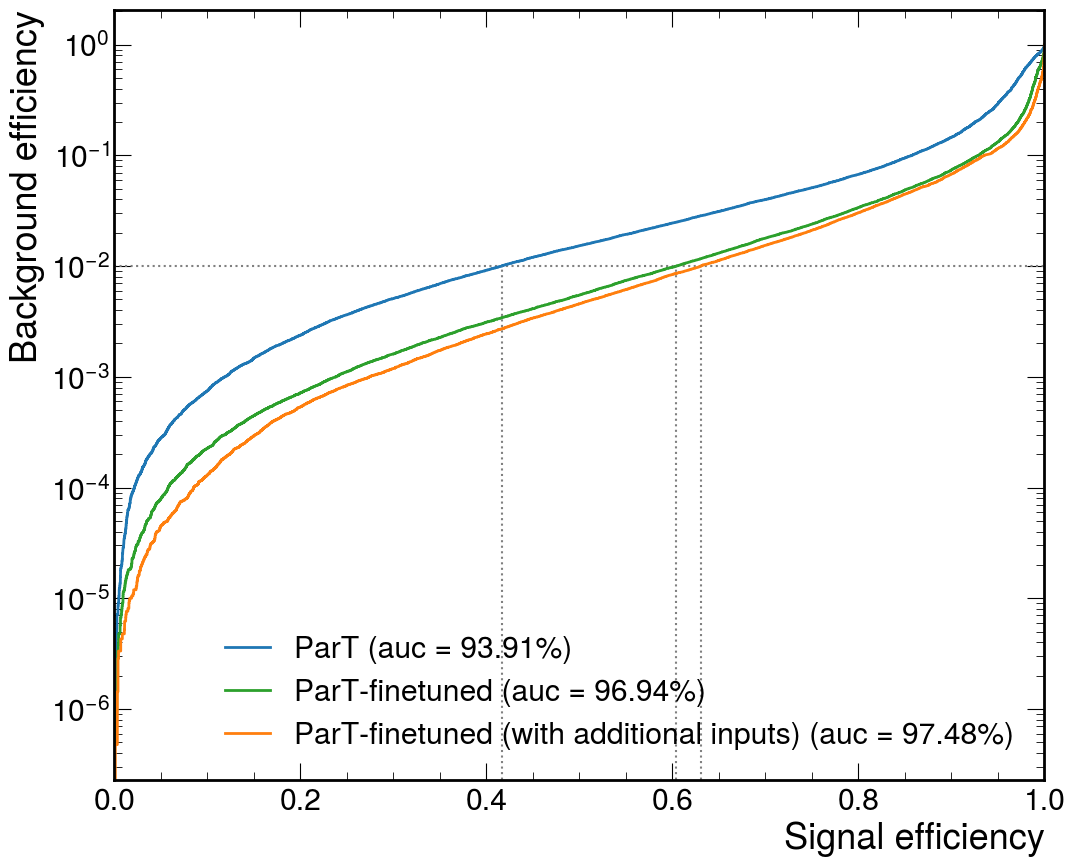

In [54]:
make_roc2(
    (events, "ParT-finetuned"), 
    (events1, "ParT-finetuned (with additional inputs)"), 
    save_as=f"/Users/fmokhtar/Desktop/AN/taggerroc.pdf", msk=None
)

v2_nor2


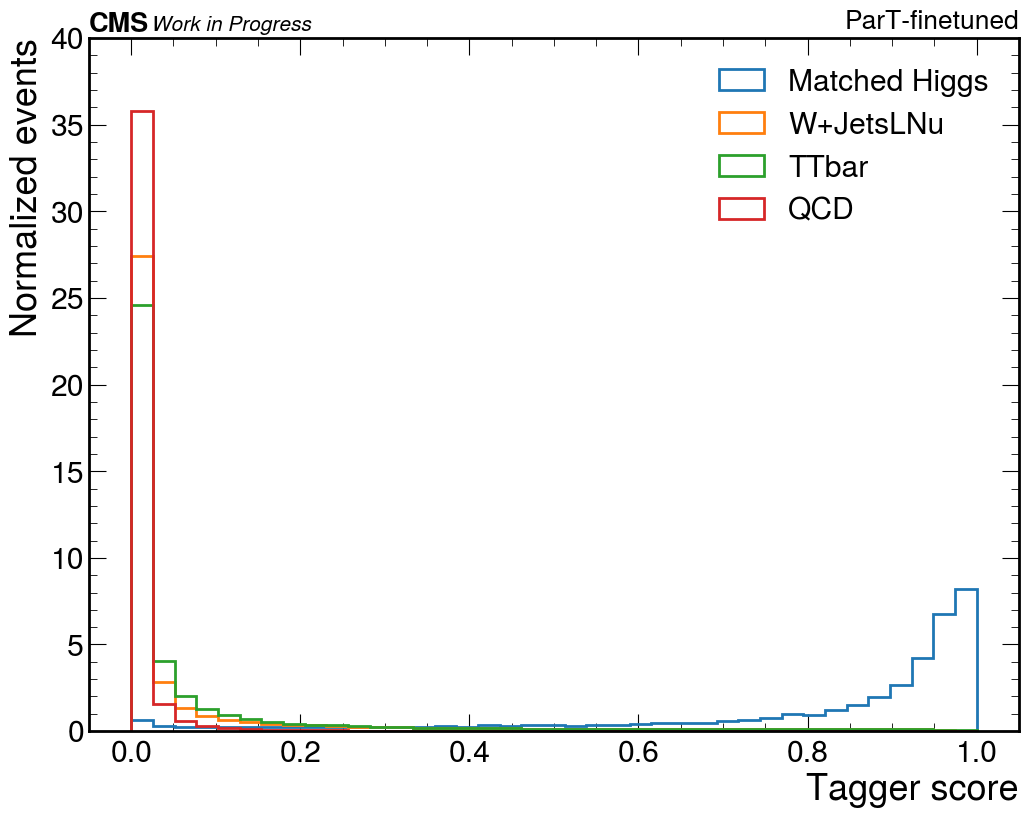

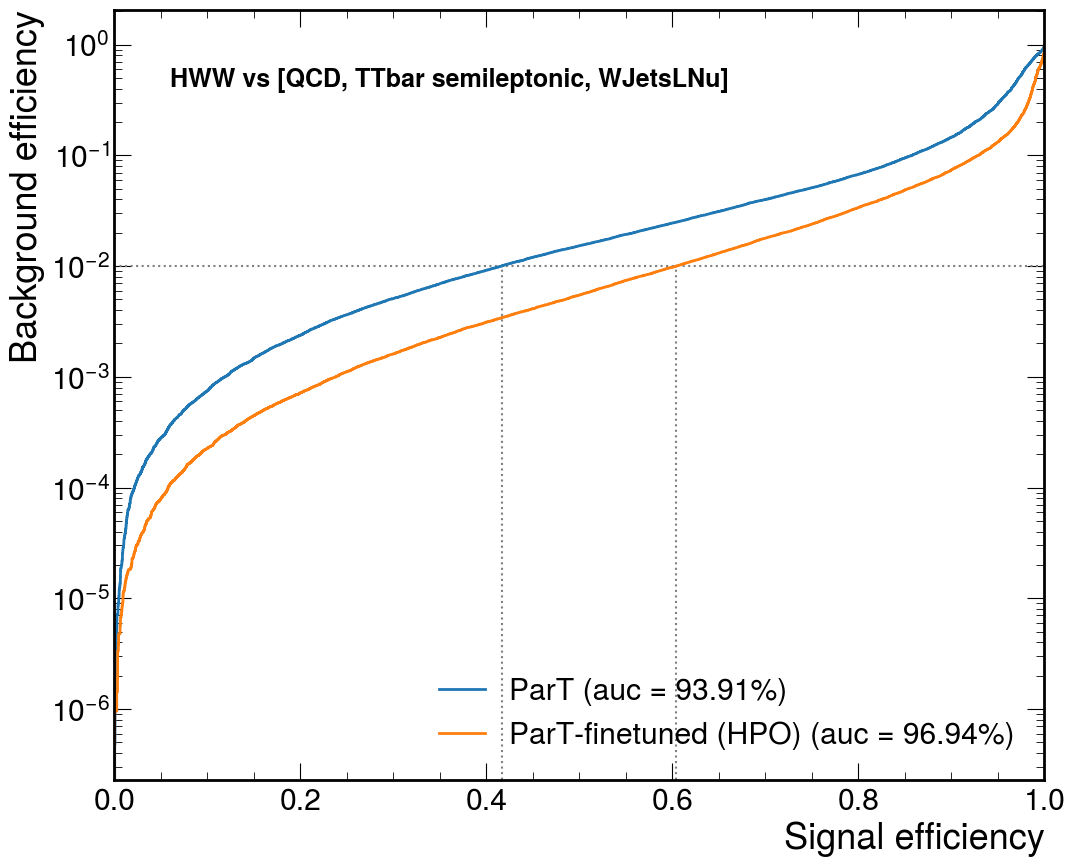

In [56]:
l = [
#     "v2_1-1",
#     "v2_1-2",
#     "v2_1-3",
#     "v2_2-1",
#     "v2_2-2",
#     "v2_2-3",
#     "v2_3-1",
#     "v2_3-2",
#     "v2_3-3",
#     "v2_4-1",
#     "v2_4-2",
#     "v2_4-3",
#     "v2_5-1",
#     "v2_5-2",
#     "v2_5-3",
#     "v2-1111-10noMass1",
#     "v2_1-12",
#     "v2_1-13",
#     "v2_10_1",
#     "v2_10_2",
#     "v2_10_3",
#     "v2_10_4",
#     "v2_10_5",
    "v2_nor2",
#     "v2_10_12",
#     "v2_10_12",    
]
for sa in l:
    print(sa)    
    if not os.path.isdir(f"finetuning/{sa}"):
        os.mkdir(f"finetuning/{sa}")    

    path = f"../experiments_finetuning/{sa}/predict/pred.root"

    events = uproot.open(path)["Events"]

#     make_1d_hists(events, tag="ParT", save_as=sa)
    make_1d_hists(events, tag="ParT-finetuned", save_as=sa)    
    make_roc(events, save_as=sa)    
#     make_roc_W(events, save_as=sa)

In [ ]:
save_as = "v2_4-1"
if not os.path.isdir(f"finetuning/{save_as}"):
    os.mkdir(f"finetuning/{save_as}")

path = f"../experiments_finetuning/{save_as}/predict/pred.root"

events = uproot.open(path)["Events"]
print(events.keys())

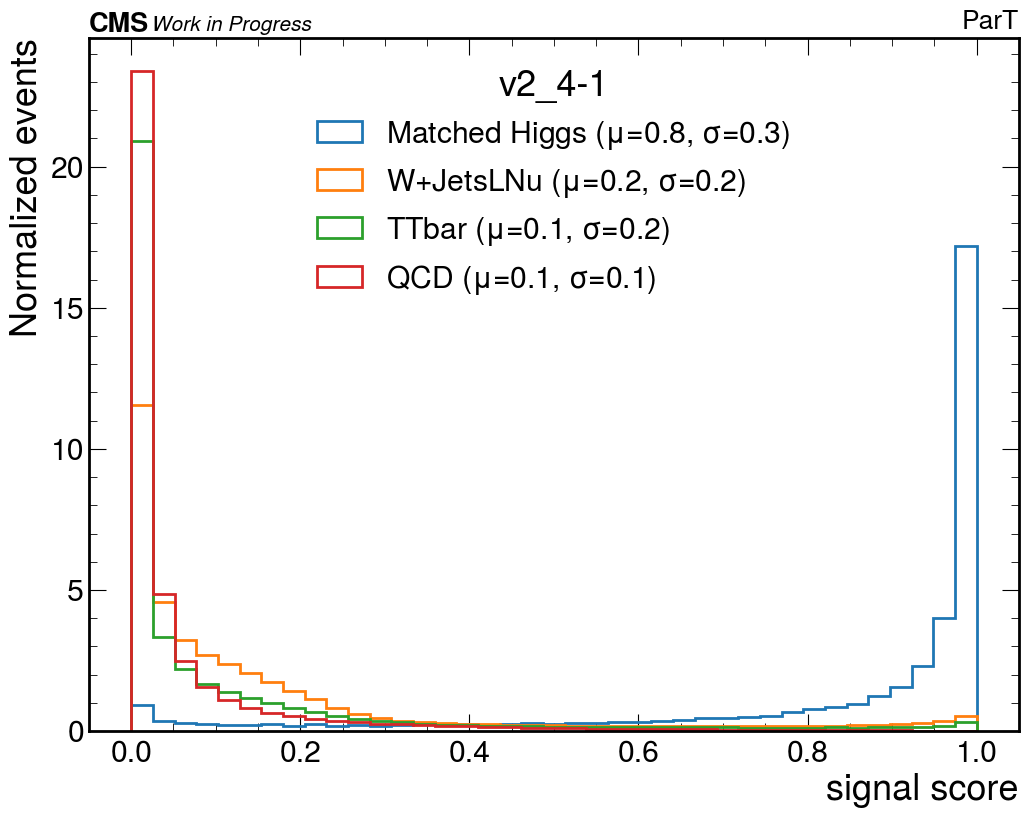

In [80]:
make_1d_hists(events, tag="ParT", save_as=save_as)

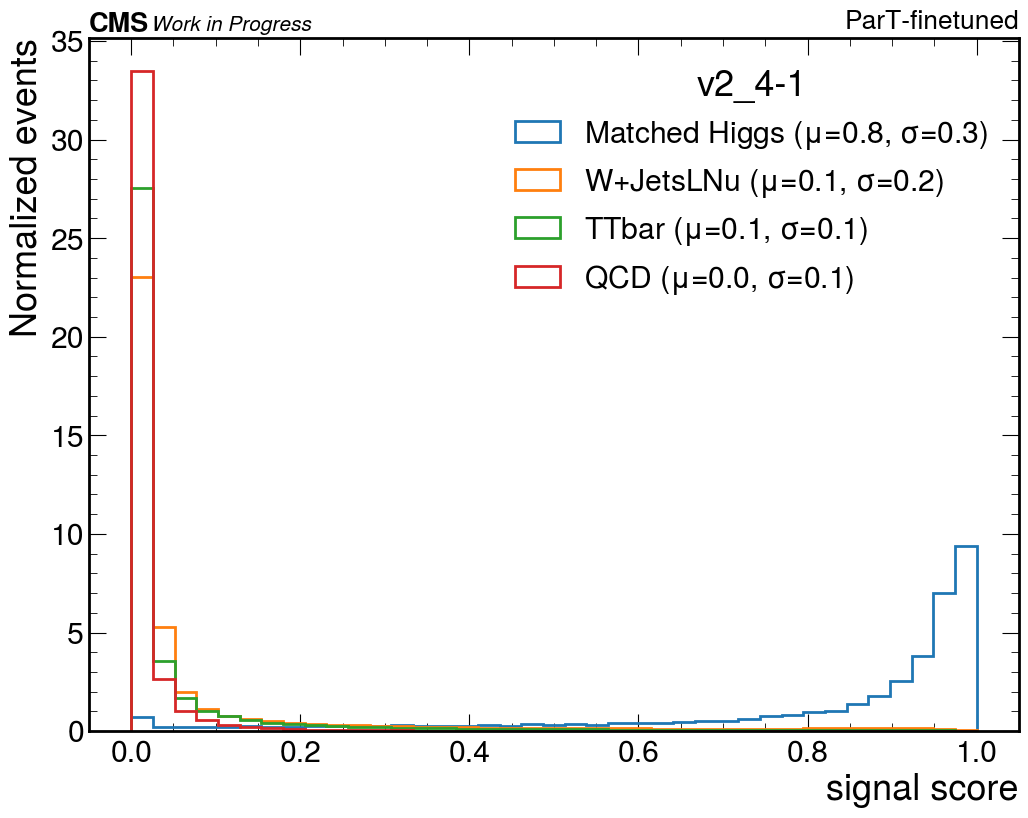

In [81]:
make_1d_hists(events, tag="ParT-finetuned", save_as=save_as)

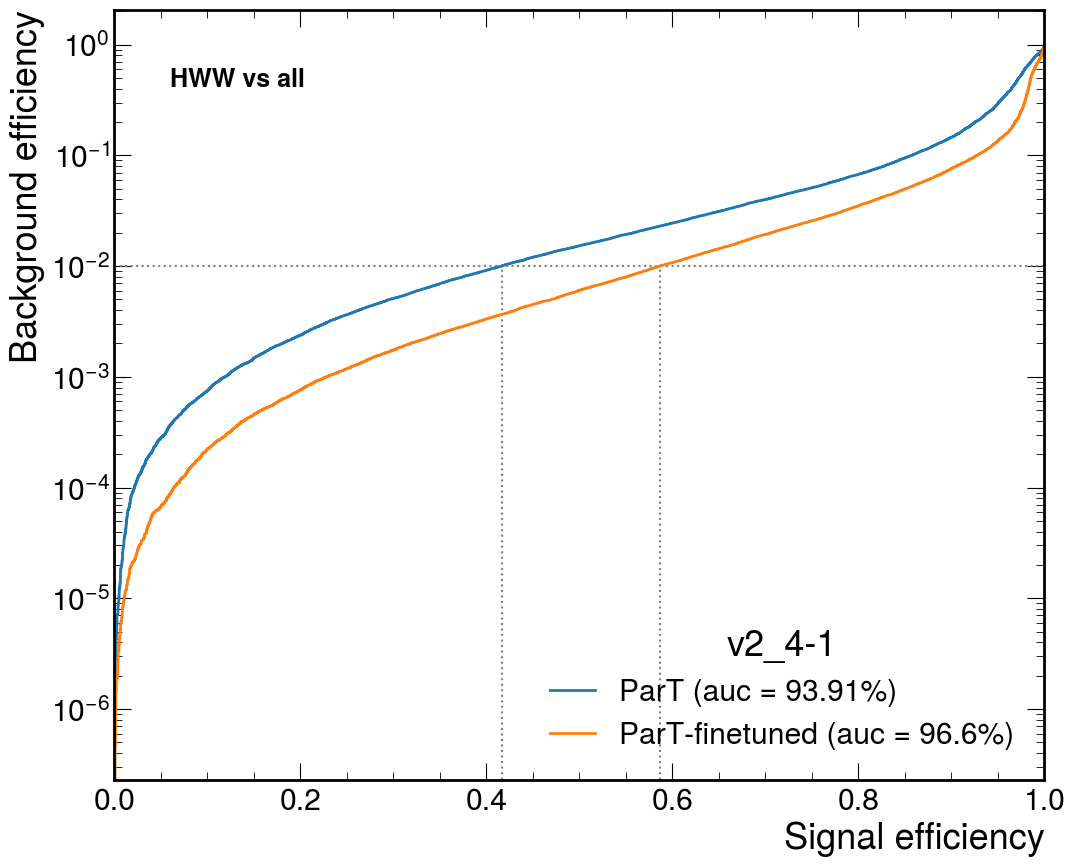

In [82]:
make_roc(events, save_as=save_as)

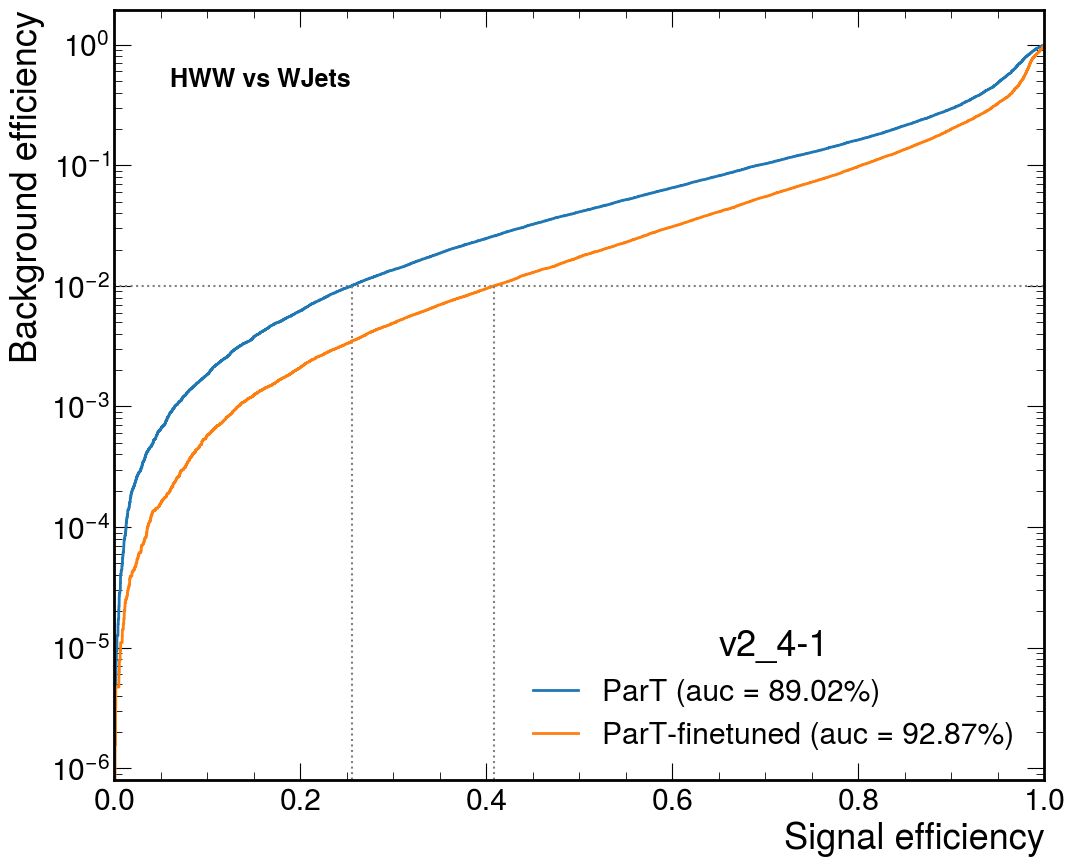

In [83]:
make_roc_W(events, save_as=save_as)

In [26]:
legend_dict = {
    "higgs": "Matched Higgs",
    "W": "W+Jets",
    "W_merged": "W merged",
    "W_unmatched": "W unmatched",
    "top": "TTbar",
    "top_fully_merged": "Top: fully merged",
    "top_W_merged": "Top: only W merged",
    "top_unmatched": "Top: unmatched",
    "qcd": "QCD"
}

def check_sculpting(sample, events, tagger_cuts, bins, tag, regressed_mass=True, finetuning=True):
    """
    Args
        sample [str]: choices are 
            ["higgs", "W_merged", "W_unmatched", "top_fully_merged", "top_W_merged", "top_unmatched", "qcd"]
        events [uproot Tree]: the uproot event Tree
        config [str]: the regressed mass config (if "ParT" then will use the ParT mass)
        tagger_cuts [list]: list of tagger cuts to make
        bins [int]: histogram bins
        
    Returns
        a 1d-plot of histograms of the `config` provided after different tagger cuts

    """
    
    
    if sample == "higgs":
        matched = (events["class_H"].array())
    elif sample == "W":
        matched = (events["class_W"].array())
    elif sample == "top":
        matched = (events["class_Top"].array())
    elif sample == "qcd":
        matched = (events["class_QCD"].array())     

    # make the plot
    fig, ax = plt.subplots(figsize=(12, 9))
    
    for tagger_wp in tagger_cuts:
        
        if tagger_wp == 0:
            title = f"No tagger cut"
        else:
            title = f"Tagger>{tagger_wp}"

        if finetuning:
            tagger_cut = events["score_class_H"].array() > tagger_wp  
            if tagger_wp != 0:
                title = f"Finetuned tagger>{tagger_wp}"
        else:
            tagger_cut = events["fj_ParT_score"].array() > tagger_wp
            if tagger_wp != 0:
                title = f"Tagger>{tagger_wp}"            

        if regressed_mass:
            x = events["fj_ParT_mass"].array()[matched & tagger_cut]
            ax.set_xlabel(f"ParT regressed mass [GeV]")          
        else:
            x = events["rec_higgs_m"].array()[matched & tagger_cut]              
            ax.set_xlabel(f"Reconstructed Higgs mass [GeV])")   
            
        ax.hist(
            x, 
            bins=np.linspace(0,250,bins), 
            density=True, 
            histtype="step", 
            linewidth=2, 
            label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
        )

    
    ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")
    ax.set_ylabel("Events")  
    ax.legend(fontsize=14)
    
    hep.cms.lumitext(
        f"{legend_dict[sample]}", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    save_as = f"{sample}_"
    if regressed_mass:
        save_as += "regressed_mass"
    else:
        save_as += "rec_higgs_m"
        
    if finetuning:
        save_as += "_finetuned"
        
    plt.savefig(f"finetuning/{tag}/{save_as}.pdf")   


def check_sculpting2(sample, events, tagger_wp, bins, tag, regressed_mass=True, finetuning=True):
    """
    Args
        sample [str]: choices are 
            ["higgs", "W_merged", "W_unmatched", "top_fully_merged", "top_W_merged", "top_unmatched", "qcd"]
        events [uproot Tree]: the uproot event Tree
        config [str]: the regressed mass config (if "ParT" then will use the ParT mass)
        tagger_cuts [list]: list of tagger cuts to make
        bins [int]: histogram bins
        
    Returns
        a 1d-plot of histograms of the `config` provided after different tagger cuts

    """
    
    
    if sample == "higgs":
        matched = (events["class_H"].array())
    elif sample == "W":
        matched = (events["class_W"].array())
    elif sample == "top":
        matched = (events["class_Top"].array())
    elif sample == "qcd":
        matched = (events["class_QCD"].array())     

    # make the plot
    fig, ax = plt.subplots(figsize=(12, 9))
    
    
    title = f"No tagger cut"
    x = events["rec_higgs_m"].array()[matched]              
       
    ax.hist(
        x, 
        bins=np.linspace(0,250,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )


    title = f"Tagger>{tagger_wp}"            
    tagger_cut = events["fj_ParT_score"].array() > tagger_wp
    x = events["rec_higgs_m"].array()[matched & tagger_cut]              
    ax.hist(
        x, 
        bins=np.linspace(0,250,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )
    
    title = f"Finetuned tagger>{tagger_wp}"
    tagger_cut = events["score_class_H"].array() > tagger_wp  
    x = events["rec_higgs_m"].array()[matched & tagger_cut]              
    ax.hist(
        x, 
        bins=np.linspace(0,250,bins), 
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

    ax.set_xlabel(f"Reconstructed Higgs mass [GeV])")
    ax.set_ylabel("Events")  
    ax.legend(fontsize=14)
    
    hep.cms.lumitext(
        f"{legend_dict[sample]}", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    save_as = f"{sample}_"
    save_as += "rec_higgs_m"
        
    save_as += f"_tagger{tagger_wp}"
        
    plt.savefig(f"finetuning/{tag}/{save_as}.pdf")   

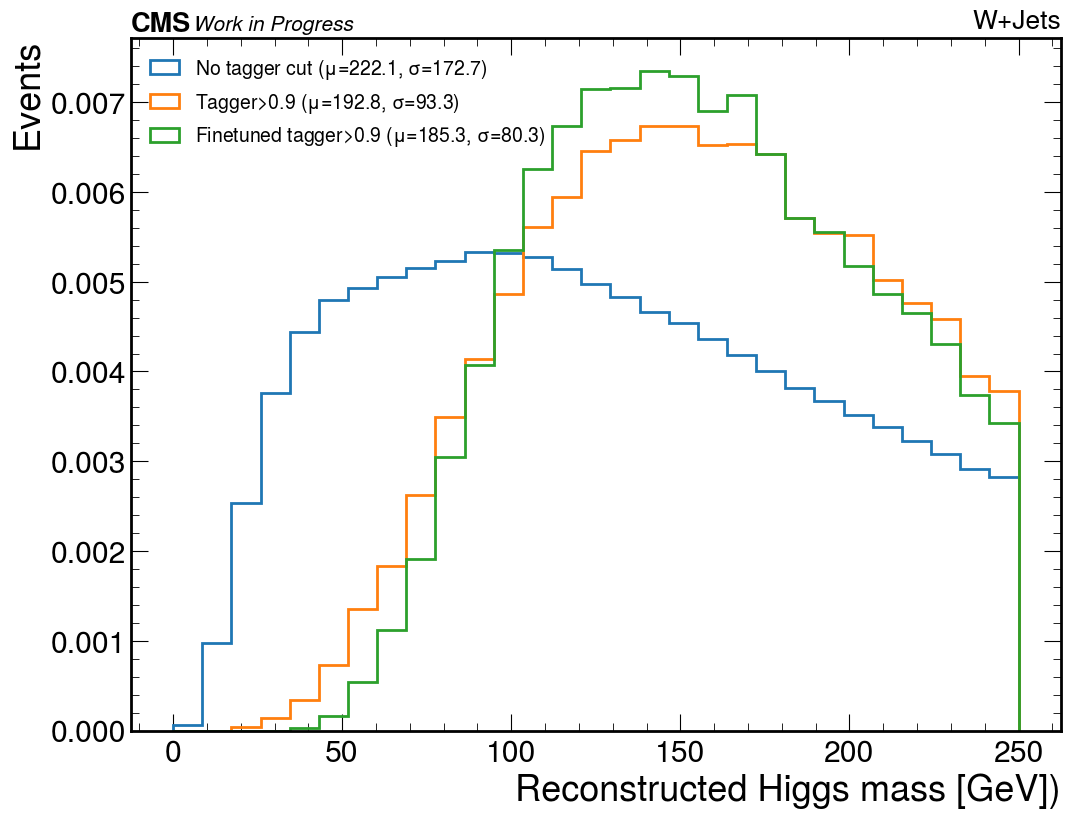

In [16]:
sample = "W"
check_sculpting2(sample, events, 0.9, bins=30, tag=save_as)

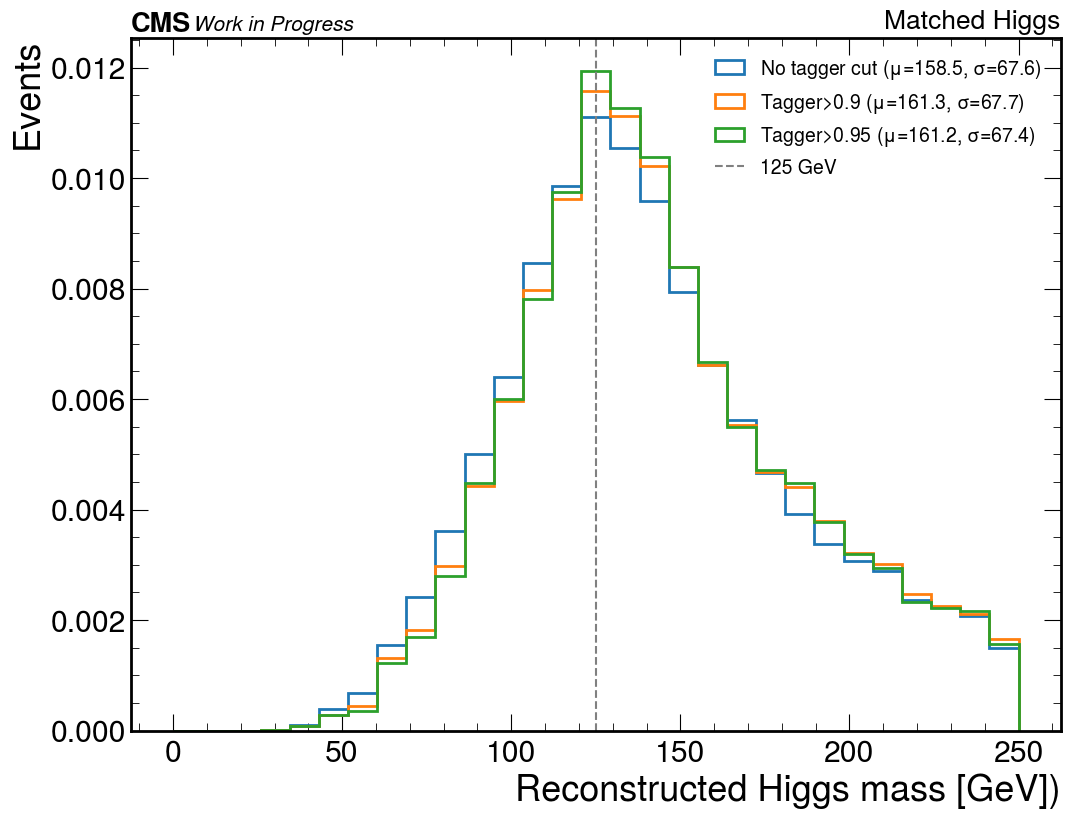

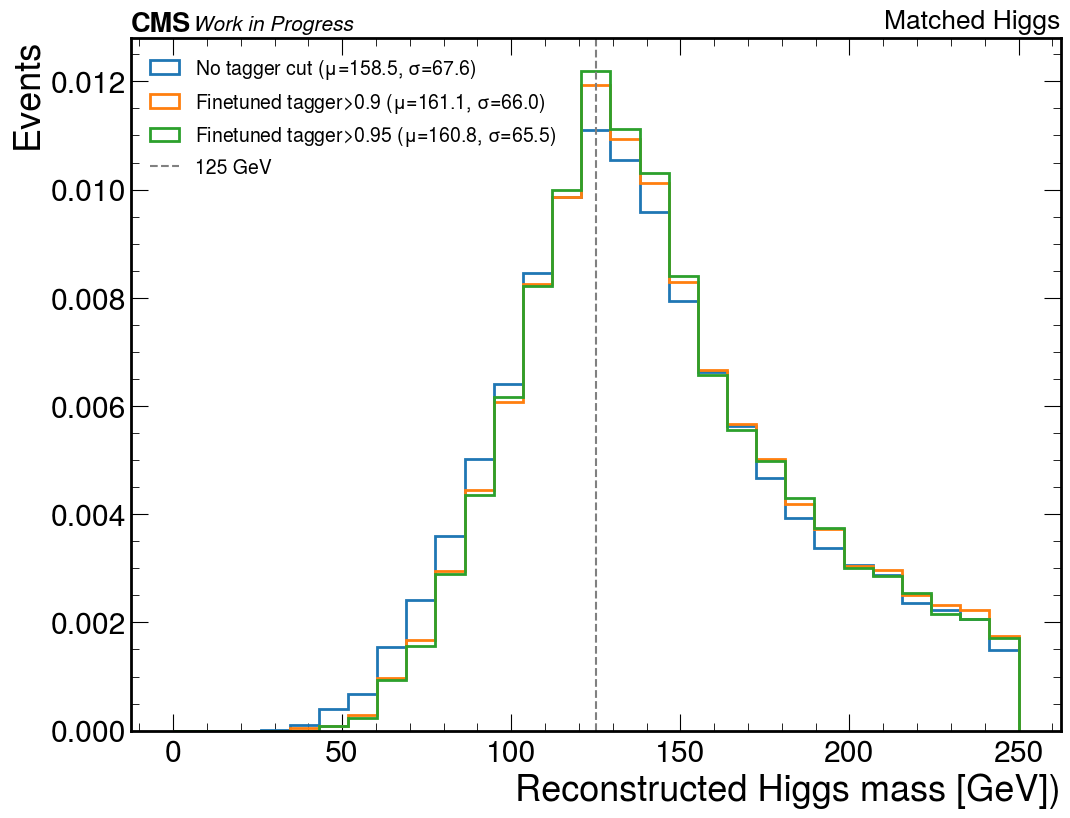

In [27]:
sample = "higgs"
check_sculpting(sample, events, [0,0.9, 0.95], bins=30, tag=save_as, regressed_mass=False, finetuning=False)
check_sculpting(sample, events, [0,0.9, 0.95], bins=30, tag=save_as, regressed_mass=False, finetuning=True)

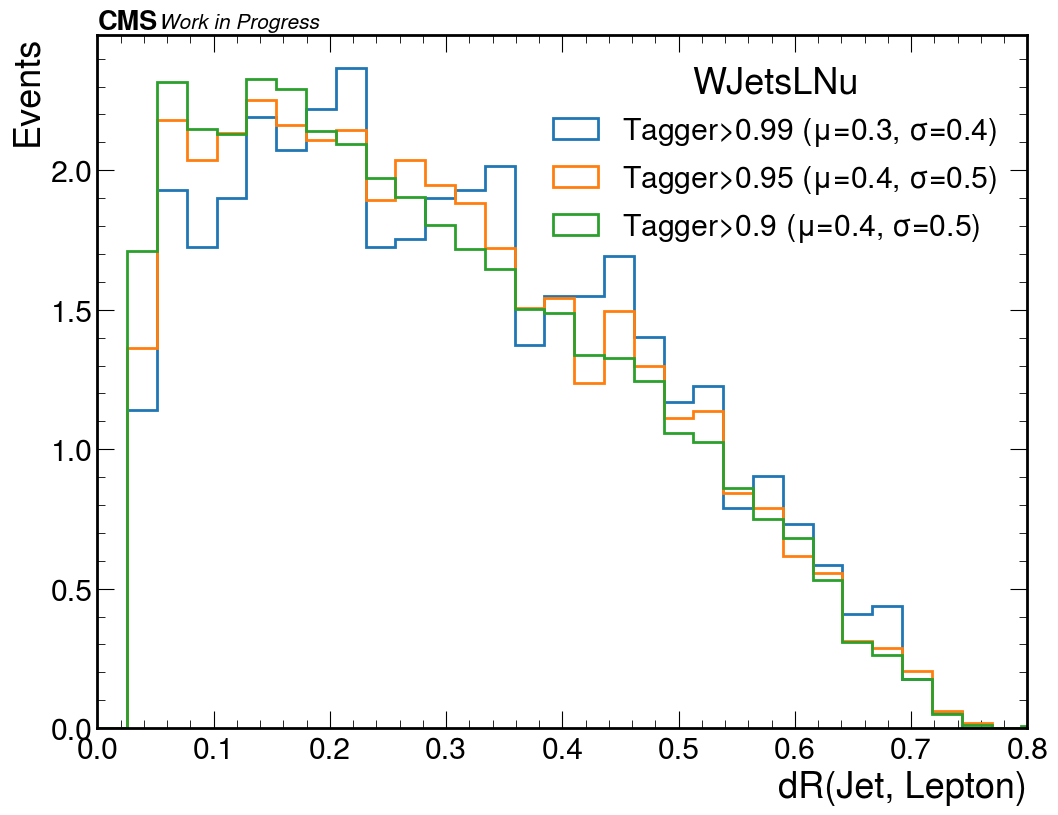

In [221]:
# make the plot
fig, ax = plt.subplots(figsize=(12, 9))

msk = events["lep_dR_fj"].array()>0.03   # mask if you want

x = events["lep_dR_fj"].array()

# matched = (events["class_H"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99)
# ax.hist(
#     x[matched], 
#     bins=np.linspace(0,1,bins), 
#     # density=True, 
#     histtype="step", 
#     linewidth=2, 
#     label=rf"{legend_dict['higgs']} ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
# )

matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.99 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    

matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.95) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.95 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    


matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.9) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.9 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    

ax.set_xlabel("dR(Jet, Lepton)")

ax.set_ylabel("Events")  
ax.legend(title="WJetsLNu")

ax.set_xlim(0,0.8)
hep.cms.lumitext(
    # f"{tag}", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/hww2/roc.pdf")    

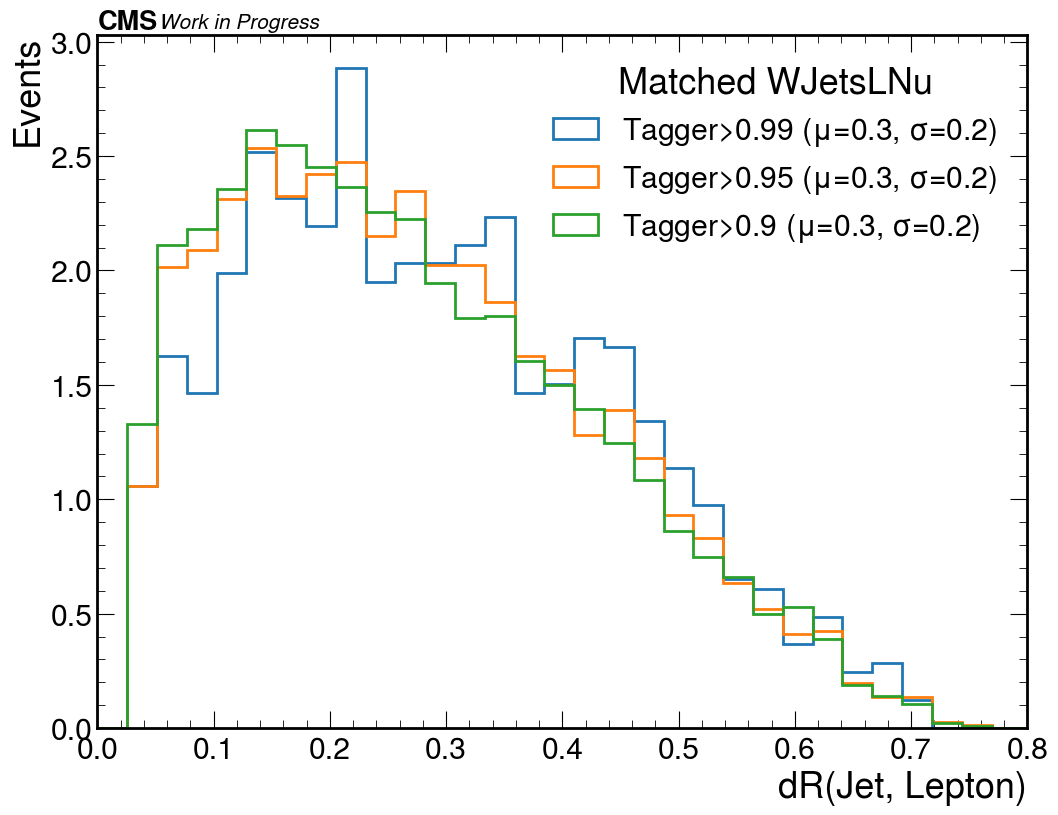

In [220]:
# make the plot

fig, ax = plt.subplots(figsize=(12, 9))

msk = events["lep_dR_fj"].array()>0.03   # mask if you want
x = events["lep_dR_fj"].array()

# matched = (events["class_H"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99)
# ax.hist(
#     x[matched], 
#     bins=np.linspace(0,1,bins), 
#     # density=True, 
#     histtype="step", 
#     linewidth=2, 
#     label=rf"{legend_dict['higgs']} ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
# )

matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99) & events["matched_mask"].array() & (events["fj_lepinprongs"].array()>0) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.99 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    

matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.95) & events["matched_mask"].array() & (events["fj_lepinprongs"].array()>0) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.95 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    


matched = (events["class_W"].array()) & (events["fj_ParT_inclusive_score"].array()>0.9) & events["matched_mask"].array() & (events["fj_lepinprongs"].array()>0) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.9 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    


# matched = (events["class_others"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99)
# ax.hist(
#     x[matched], 
#     bins=np.linspace(0,1,bins), 
#     density=True, 
#     histtype="step", 
#     linewidth=2, 
#     label=rf"Others ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
# ) 


ax.set_xlabel("dR(Jet, Lepton)")

ax.set_ylabel("Events")  
ax.legend(title="Matched WJetsLNu")

ax.set_xlim(0,0.8)
hep.cms.lumitext(
    # f"{tag}", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/hww2/roc.pdf")    

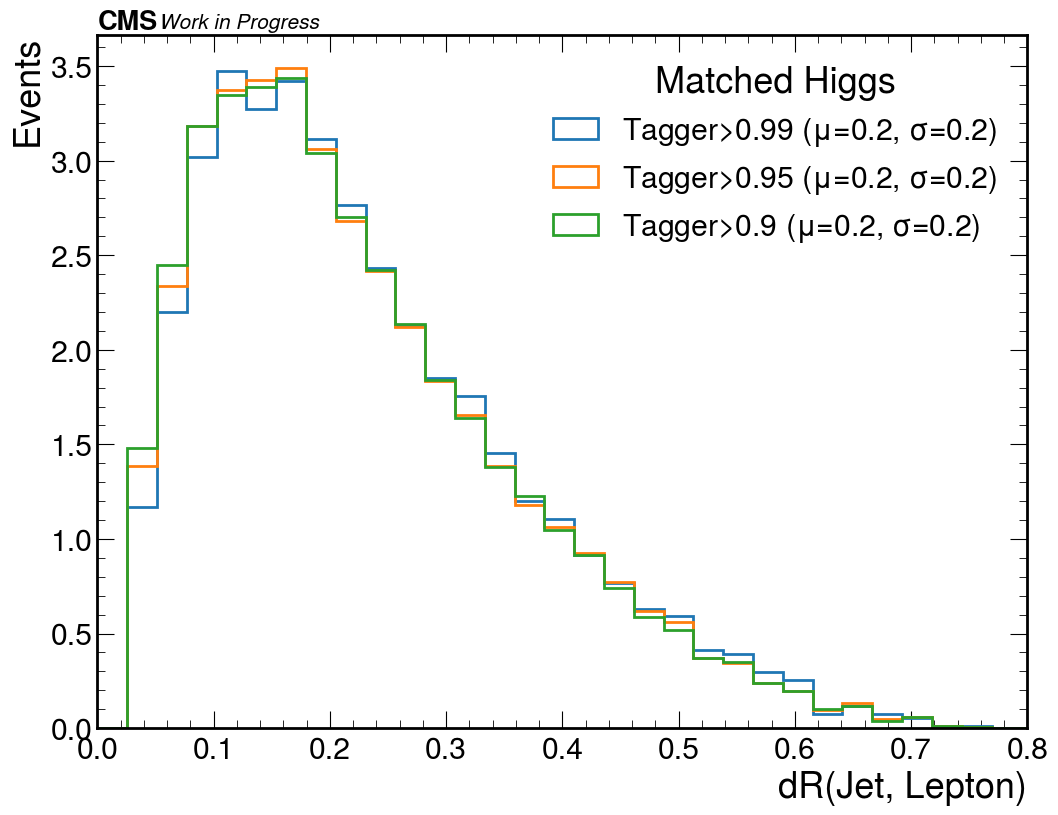

In [219]:
# make the plot
fig, ax = plt.subplots(figsize=(12, 9))

msk = events["lep_dR_fj"].array()>0.03   # mask if you want
x = events["lep_dR_fj"].array()

matched = (events["class_H"].array()) & (events["fj_ParT_inclusive_score"].array()>0.99) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.99 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    

matched = (events["class_H"].array()) & (events["fj_ParT_inclusive_score"].array()>0.95) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.95 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    


matched = (events["class_H"].array()) & (events["fj_ParT_inclusive_score"].array()>0.9) & msk
ax.hist(
    x[matched], 
    bins=np.linspace(0,1,bins), 
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"Tagger>0.9 ($\mu$={np.mean(x[matched]):.1f}, $\sigma$={np.std(x[matched]):.1f})"
)    

ax.set_xlabel("dR(Jet, Lepton)")

ax.set_ylabel("Events")  
ax.legend(title="Matched Higgs")

ax.set_xlim(0,0.8)
hep.cms.lumitext(
    # f"{tag}", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/hww2/roc.pdf")    

# DeltaR as a discriminator

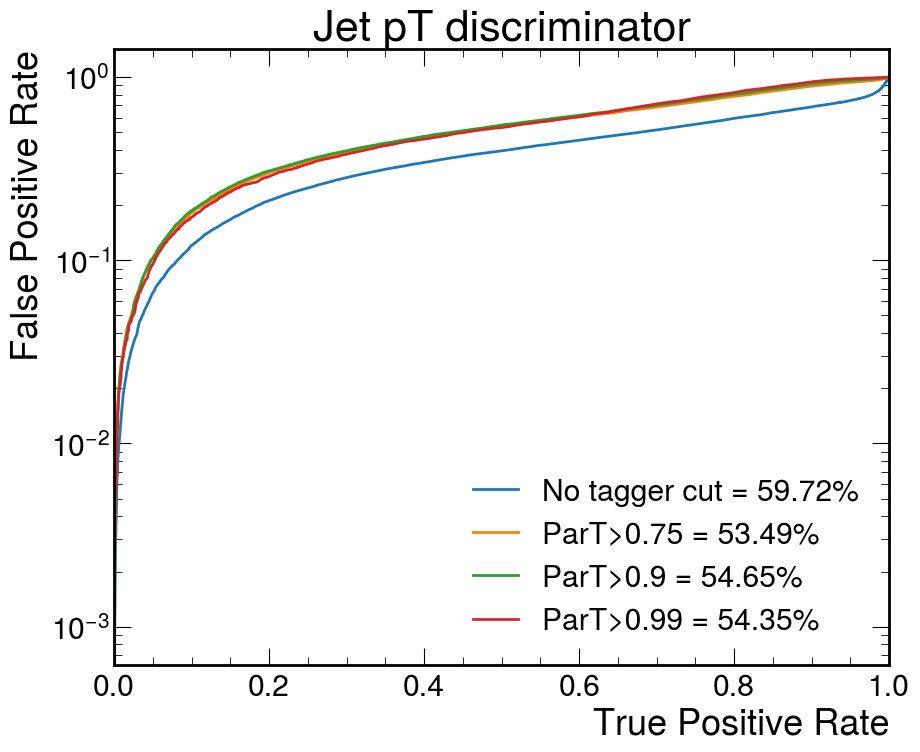

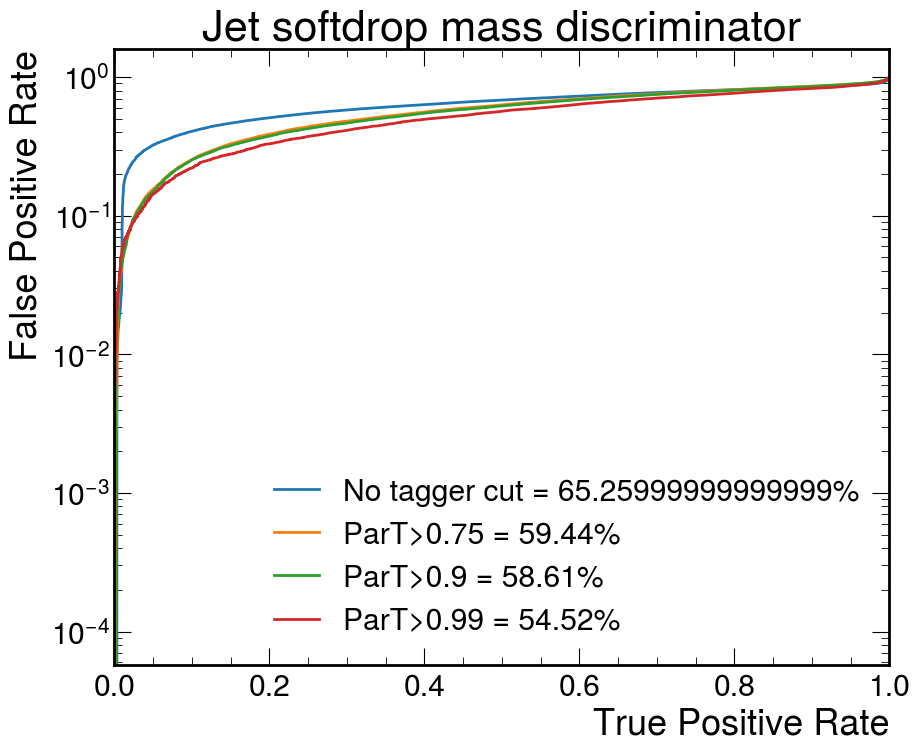

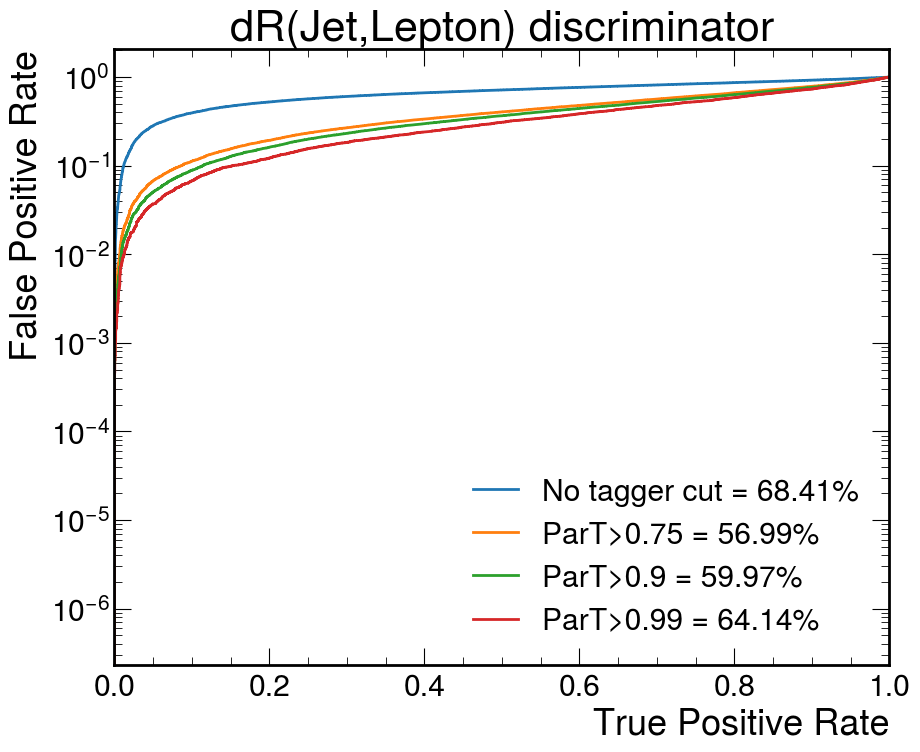

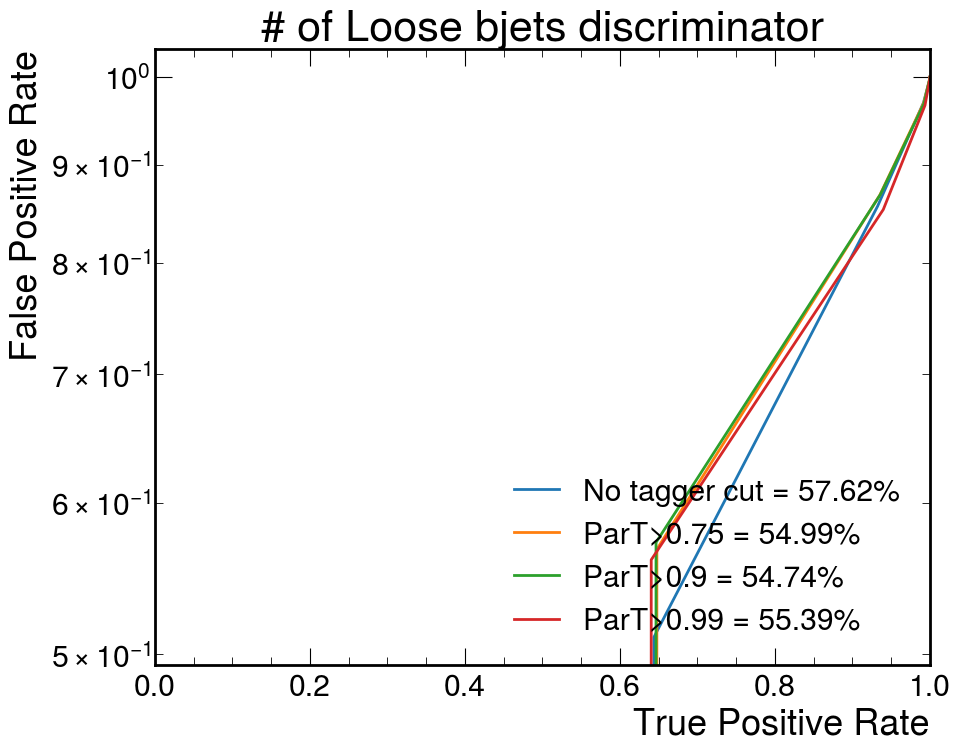

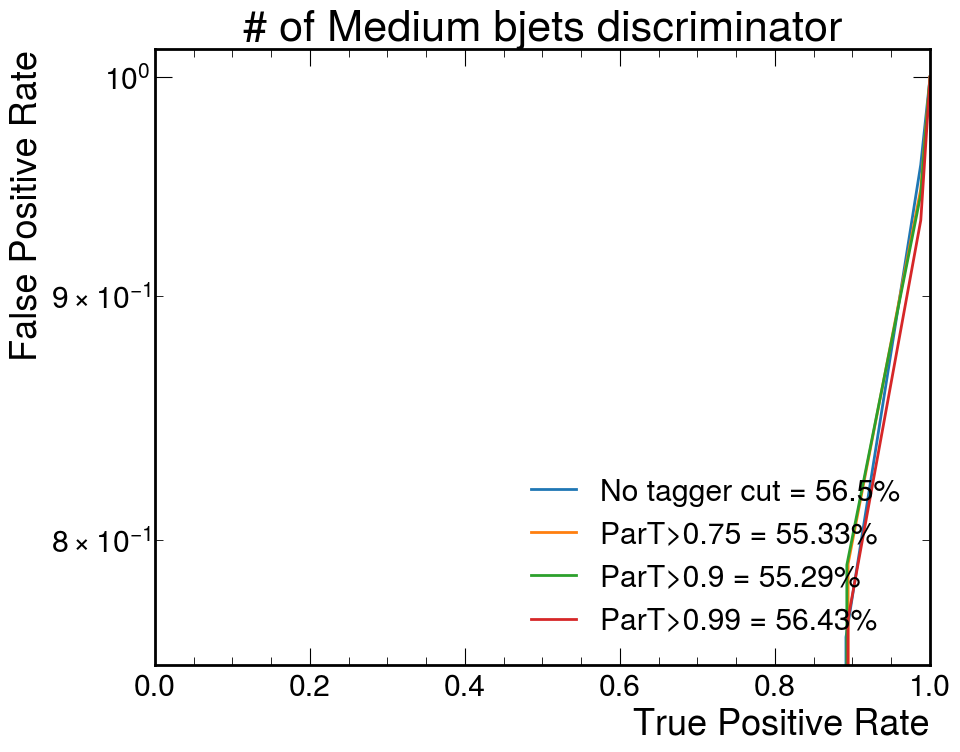

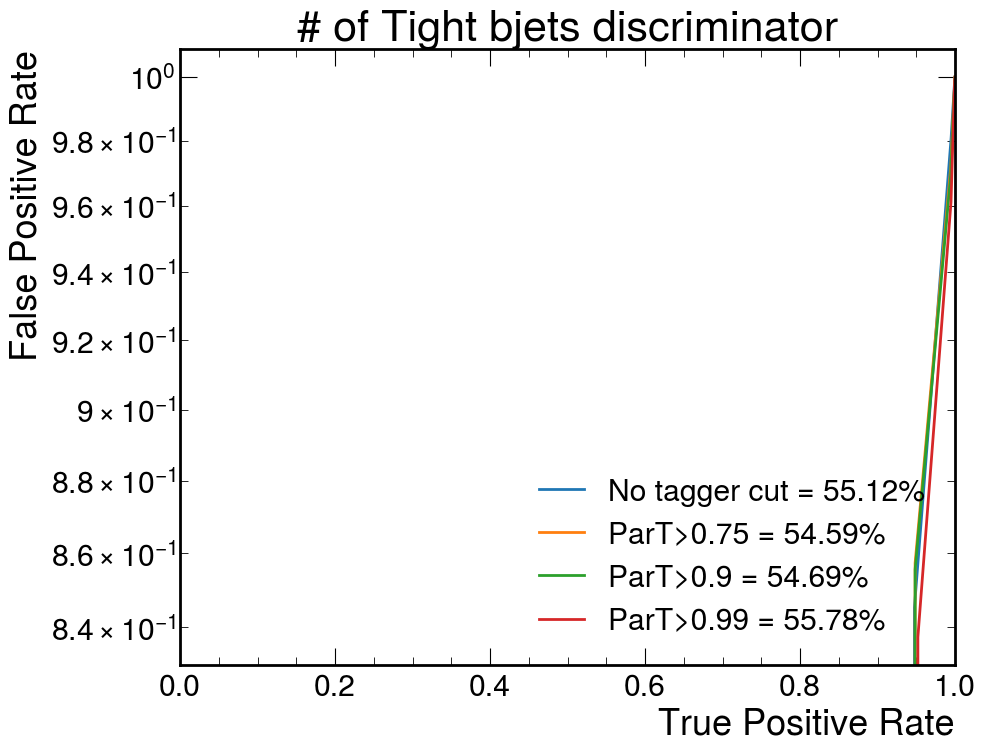

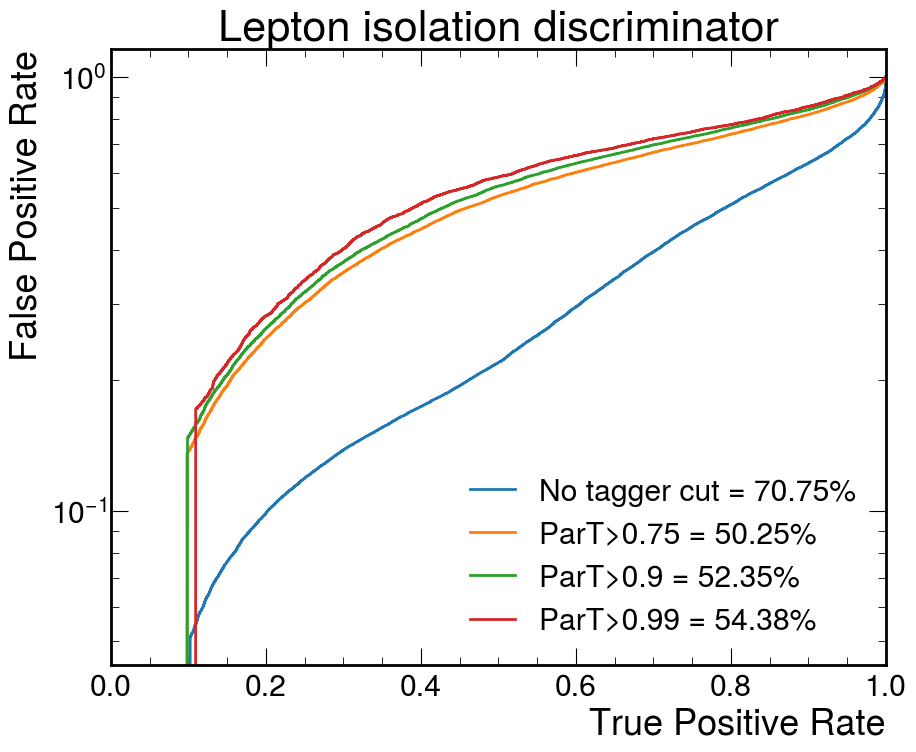

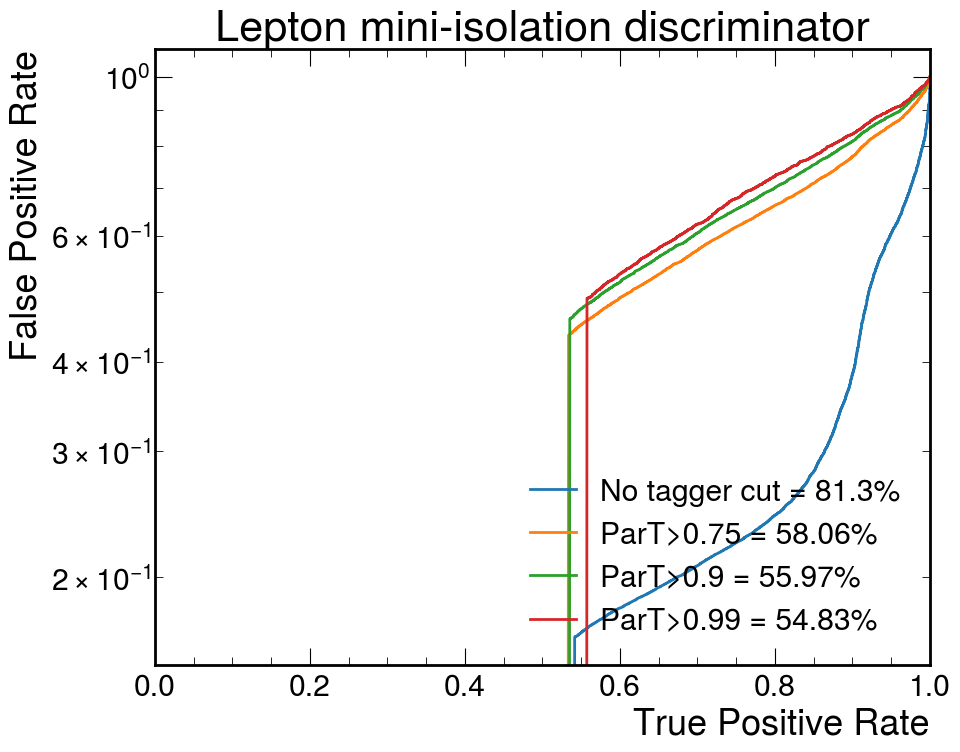

In [45]:
labs = {
    "fj_pt": "Jet pT",
    "fj_msoftdrop": "Jet softdrop mass",
    # "met_relpt": "MET.pT / Jet.pT",
    "lep_dR_fj": "dR(Jet,Lepton)",
    "n_bjets_L": "# of Loose bjets",
    "n_bjets_M": "# of Medium bjets",
    "n_bjets_T": "# of Tight bjets",
    "lep_reliso": "Lepton isolation",
    "lep_miso": "Lepton mini-isolation",    
}


msk = events["lep_dR_fj"].array()>0.03   # mask if you want


for var in labs:
    # var = "fj_pt"
    tagger = "fj_ParT_score"
    # tagger = "score_class_H"
    
    y_truth = (events["class_H"].array().to_numpy()*1)
    y_score = (1-(events[var].array().to_numpy()/events[var].array().to_numpy().max()))
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    for tagger_cut in [0, 0.75, 0.9, 0.99]:
    
        if tagger_cut==0:
            label = "No tagger cut"
        else:
    
            if tagger == "fj_ParT_score":
                label = f"ParT>{tagger_cut}"
            else:
                label = f"ParT-finetuned>{tagger_cut}"
        
        fpr, tpr, _ = roc_curve(y_truth[(events[tagger].array()>tagger_cut) & msk], y_score[(events[tagger].array()>tagger_cut) & msk])
    
        auc_ = round(auc(fpr, tpr)*100,2)
        if auc_ < 50:
            auc_ = 100-auc_
            
        ax.plot(
            tpr,
            fpr,
            lw=2,
            label=f"{label} = {auc_}%",
        )    
    
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(loc="lower right")
    plt.title(f"{labs[var]} discriminator")
    
    plt.savefig(f"/Users/fmokhtar/Desktop/hwwTEST/deltaR/{tagger}_{var}.pdf")

In [37]:
auc

59.72